In [17]:
# ============================================
# 1. CARGA DE LIBRERÍAS
# ============================================
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import gradio as gr

# ============================================
# 2. CARGA DEL DATASET
# ============================================
df = pd.read_csv("crude suicide rates.csv")

df.head()

,Unnamed: 0,Unnamed: 1,"Probability (%) of dying between age 30 and exact age 70 from any of cardiovascular disease, cancer, diabetes, or chronic respiratory disease","Probability (%) of dying between age 30 and exact age 70 from any of cardiovascular disease, cancer, diabetes, or chronic respiratory disease.1","Probability (%) of dying between age 30 and exact age 70 from any of cardiovascular disease, cancer, diabetes, or chronic respiratory disease.2",Crude suicide rates (per 100 000 population),Crude suicide rates (per 100 000 population).1,Crude suicide rates (per 100 000 population).2
0,Country,Year,Both sexes,Male,Female,Both sexes,Male,Female
1,Afghanistan,2016,29.8,31.8,27.7,4.7,7.6,1.5
2,Afghanistan,2015,29.8,31.9,27.8,4.8,7.8,1.5
3,Afghanistan,2010,31.7,34.1,29.4,5.1,8.6,1.4
4,Afghanistan,2005,34.1,36.5,31.6,6.3,10.8,1.5


In [18]:
# ============================================
# 3. SELECCIÓN DE VARIABLES RELACIONADAS A SALUD MENTAL
# ============================================
cols_mhealth = [
    "Unnamed: 1", # Year
    "Crude suicide rates (per 100 000 population)" # Suicide rate for both sexes
]

# Select columns, drop the first row which contains string headers from the original CSV
# and convert columns to numeric
df_mh = df[cols_mhealth].iloc[1:].copy()
df_mh.columns = ['Year', 'Suicide Rate (Both Sexes)']
df_mh['Year'] = pd.to_numeric(df_mh['Year'], errors='coerce')
df_mh['Suicide Rate (Both Sexes)'] = pd.to_numeric(df_mh['Suicide Rate (Both Sexes)'], errors='coerce')

# Drop any rows that might have become NaN during the conversion
df_mh.dropna(inplace=True)

df_mh.head()

,Year,Suicide Rate (Both Sexes)
1,2016,4.7
2,2015,4.8
3,2010,5.1
4,2005,6.3
5,2000,5.7


In [19]:
# ============================================
# 4. NORMALIZACIÓN
# ============================================
scaler = StandardScaler()
X = scaler.fit_transform(df_mh)



In [20]:
# ============================================
# 5. ENCONTRAR EL MEJOR NÚMERO DE CLUSTERS
# ============================================
inertias = []
sils = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)

    inertias.append(kmeans.inertia_)
    sils.append(silhouette_score(X, labels))

best_k = K_range[np.argmax(sils)]

print("Mejor número de clusters (silueta):", best_k)

Mejor número de clusters (silueta): 3


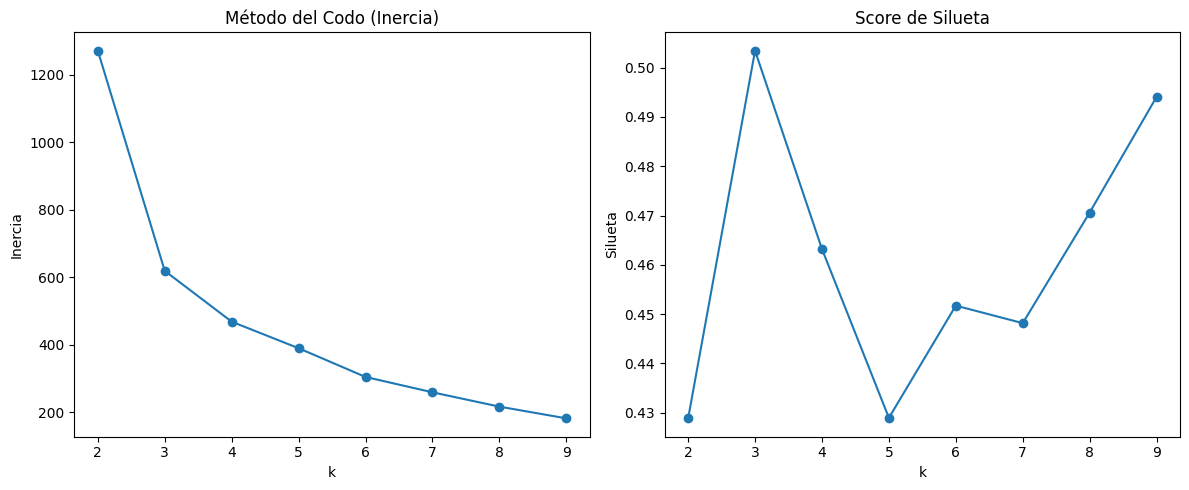

In [21]:
# ============================================
# 6. VISUALIZACIÓN DEL CODO Y SILUETA
# ============================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, inertias, marker="o")
plt.title("Método del Codo (Inercia)")
plt.xlabel("k")
plt.ylabel("Inercia")

plt.subplot(1,2,2)
plt.plot(K_range, sils, marker="o")
plt.title("Score de Silueta")
plt.xlabel("k")
plt.ylabel("Silueta")

plt.tight_layout()
plt.show()


In [22]:
# ============================================
# 7. ENTRENAR K-MEANS FINAL
# ============================================
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans_final.fit_predict(X)

df_mh["Cluster"] = labels
df_mh.head()


,Year,Suicide Rate (Both Sexes),Cluster
1,2016,4.7,0
2,2015,4.8,0
3,2010,5.1,0
4,2005,6.3,1
5,2000,5.7,1


In [23]:
# ============================================
# 8. PCA PARA VISUALIZACIÓN
# ============================================
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

df_pca = pd.DataFrame({
    "PC1": pca_result[:,0],
    "PC2": pca_result[:,1],
    "Cluster": labels
})

px.scatter(df_pca, x="PC1", y="PC2", color=df_pca["Cluster"].astype(str),
           title="Visualización PCA por Clusters")


In [24]:
# ============================================
# 9. ANÁLISIS POR CLUSTER (PARA EL MÉDICO)
# ============================================
analysis = df_mh.groupby("Cluster").mean()

analysis


,Year,Suicide Rate (Both Sexes)
Cluster,,
0,2013.729084,8.049801
1,2002.468944,8.187888
2,2008.032967,26.523077


In [25]:
# ============================================
# 10. GENERAR TEXTO DE ANÁLISIS POR CLUSTER
# ============================================
cluster_report = ""

for c in sorted(df_mh["Cluster"].unique()):
    data = analysis.loc[c]

    cluster_report += f"\n\n### 🔹 Cluster {c}\n"
    cluster_report += f"- Promedio de suicidios: {data['Suicide Rate (Both Sexes)']:.2f}\n"
    # The following lines are commented out because these columns are not available in the current dataset
    # cluster_report += f"- Depresión estimada: {data['Estimated share of people with depression (%)']:.2f}%\n"
    # cluster_report += f"- Alcohol disorders: {data['Alcohol use disorders (%)']:.2f}%\n"
    # cluster_report += f"- Drogas: {data['Drug use disorders (%)']:.2f}%\n"
    # cluster_report += f"- DALYs asociados: {data['DALYs from mental health and substance use disorders (per 100,000)']:.2f}\n"

    # Interpretación general sin detalles sensibles:
    if data["Suicide Rate (Both Sexes)"] > analysis["Suicide Rate (Both Sexes)"].mean():
        cluster_report += "- **Interpretación:** Grupo con indicadores elevados de riesgo asociado a salud mental.\n"
    else:
        cluster_report += "- **Interpretación:** Grupo con indicadores relativamente más bajos.\n"

cluster_report

'\n\n### 🔹 Cluster 0\n- Promedio de suicidios: 8.05\n- **Interpretación:** Grupo con indicadores relativamente más bajos.\n\n\n### 🔹 Cluster 1\n- Promedio de suicidios: 8.19\n- **Interpretación:** Grupo con indicadores relativamente más bajos.\n\n\n### 🔹 Cluster 2\n- Promedio de suicidios: 26.52\n- **Interpretación:** Grupo con indicadores elevados de riesgo asociado a salud mental.\n'

In [26]:
# ============================================
# 11. INTERFAZ EN GRADIO PARA CONSUMO DEL MODELO (CORREGIDO)
# ============================================

def predict_cluster(year, suicide_rate):
    try:
        data = np.array([[float(year), float(suicide_rate)]])
        scaled = scaler.transform(data)
        pred = kmeans_final.predict(scaled)[0]
        return f"Pertenece al cluster: {pred}"
    except Exception as e:
        return f"Error: {e}"

interface = gr.Interface(
    fn=predict_cluster,
    inputs=[
        gr.Number(label="Año"),
        gr.Number(label="Tasa de suicidio (100k)"),
    ],
    outputs="text",
    title="Modelo de Segmentación de Salud Mental"
)

interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://41e77125af64ef54c3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
